# Gaussian Processes for Regression

In this tutorial we're going to discuss the humble **Gaussian Process**, a popular method for performing regression. 

It's worth noting that for the sake of illustration, there is a lot of plotting code in this notebook. I have commented where the plotting code is, feel free to skip over it since it's not important for the actual subject.

Broadly speaking, most tasks in data science are either classification, or regression. In this tutorial I'm only going to discuss regression (though GPs are capable of doing classification, they are most naturally suited to regression).

## The Gaussian Distribution 

The Gaussian distribution (also commonly referred to as the Normal distribution) is one of the most heavily used distributions in data science and machine learning. This is in large part because they appear so often in the world, (see: [central limit theorem](https://www.khanacademy.org/math/ap-statistics/sampling-distribution-ap/sampling-distribution-mean/v/central-limit-theorem)), but also because they offer a great deal of mathematical convenience.

A _univariate_ Gaussian distribution is specified by a mean ($\mu$) and a variance ($\sigma^2$). This is often shorted to: $ \mathcal{N}(\mu, \sigma^2) $. 

To evaluate the probability that the Gaussian assigns to an input location $y$, we use the formula:

$$ p(x|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}} \exp \bigg\{ -\frac{1}{2\sigma^2}(x-\mu)^2\bigg\} $$

It's easiest to picture this.

First I'm going to import some libraries:

In [1]:
%matplotlib inline

## imports and setup
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
plt.style.use('seaborn-whitegrid')

from matplotlib import animation, rc
from IPython.display import HTML

np.random.seed(42) ## seed the random generator so the notebook is reproducible 

font = {'size'   : 15}
matplotlib.rc('font', **font)

Now we can illustrate:

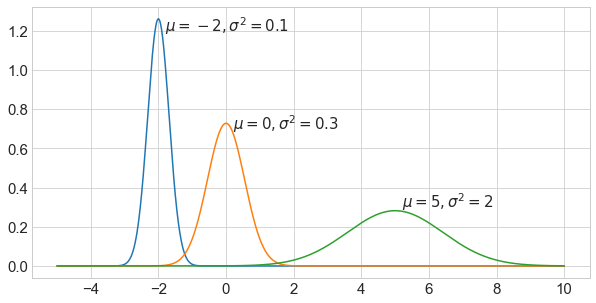

In [69]:
def gaussian(x, mu,sig):
    return 1./(sig * np.sqrt(2.*np.pi))*np.exp(-np.power((x - mu)/sig, 2.)/2)

mu1, sigma1 = -2, np.sqrt(0.1)
mu2, sigma2 = 0, np.sqrt(0.3)
mu3, sigma3 = 5, np.sqrt(2)

## plotting code
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(-5,10,1000)

ax.plot(x, ([gaussian(x_, mu1, sigma1) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu2, sigma2) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu3, sigma3) for x_ in x]))

ax.annotate('$\mu=-2, \sigma^2=0.1$', (-1.8,1.2))
ax.annotate('$\mu=0, \sigma^2=0.3$', (0.2,0.7))
ax.annotate('$\mu=5, \sigma^2=2$', (5.2,0.3))

plt.show()

Notice in particular that the *variance* parameter, $\sigma$, describes the width of the Gaussian. If the width is small, then the peak (around the mean) is higher. Intuitively, a wider Gaussian means that there is a wider range of possible values, therefore we expect to see each one of them a little less often.

Imagine we are modelling the height (in centimetres) of a population. We could specify that the mean height of the population was 160cm, with a variance of 10cm ($H_{cm} \sim \mathcal{N}(160, 10^2)$).

We can plot a _probability density_ for this using the Gaussian equation. The _density_ at a given height (in cm) tells us how often we can expect to see people at that height. 

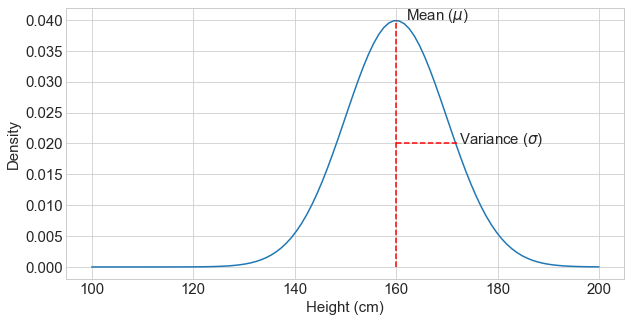

In [70]:
mu, sigma = 160, 10
population_size = 100

# on the x axis, we want all of the heights between 100cm and 200cm
heights = np.linspace(100,200,population_size) # 100 samples
density = [gaussian(x, mu, sigma) for x in heights]



#### plotting code: you can ignore this since it's just annotating
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

ax.plot([160]*10,np.linspace(0,.04,10), linestyle='--', color='red')
ax.plot(np.linspace(160,172,10), [0.02]*10, linestyle='--', color='red')

ax.annotate("Mean ($\mu$)",(162, .04))
ax.annotate("Variance ($\sigma$)", (172.5,0.02))

ax.set_xlabel('Height (cm)')
ax.set_ylabel('Density')
plt.show()

#### Sampling from a Gaussian

One of the benefits of defining our population this way is that we can take samples. We could take 100 samples from our Gaussian (each sample representing the height of one person), and we would expect this list of 100 heights to be roughly representative of our real population.
 
`numpy` provides a particularly simple way to sample from Gaussians. E.g. to take `n` samples:

```
n_samples = np.random.normal(mu, sigma, n) 
```
 
To picture what this looks like, imagine that each of the crosses on the below plot are individual samples from our model:

Samples: 
 [164.96714153 158.61735699 166.47688538 175.23029856 157.65846625
 157.65863043 175.79212816 167.67434729 155.30525614 165.42560044
 155.36582307 155.34270246 162.41962272 140.86719755 142.75082167
 154.37712471 149.8716888  163.14247333 150.91975924 145.87696299]


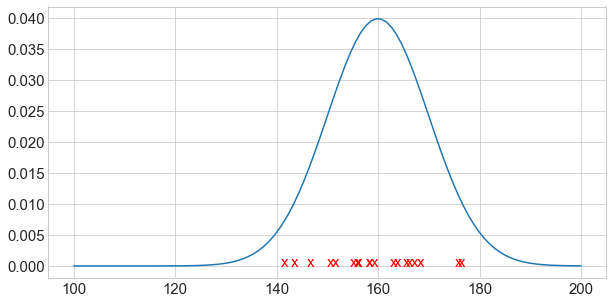

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

## let's sample
n = 20
samples = np.random.normal(mu, sigma, n)

print('Samples: \n', samples)

for s in samples:
    ax.annotate('x',(s,0), color='red')

plt.show()

Imagine now that we would also like to incorporate _weight_ (in kg) into our model. 

We could define a new Gaussian distribution, with a different mean and variance. If we wanted to sample a new person (represented by a pair of a height and a weight $(h,w)$, we could first draw a sample from our model of height, and then another from our model of weight.


Example of a sampled person: 
    height (cm):  [174.65648769]
    weight (kg):  [48.8711185]


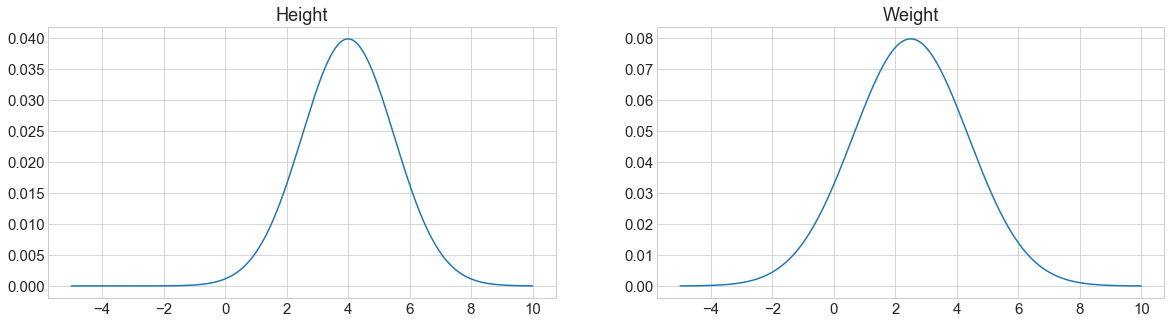

In [5]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs = axs.ravel()

mu_h, sigma_h = 160, 10
mu_w, sigma_w = 50, 5

x_h = np.linspace(100,200,1000)
x_w = np.linspace(30,70,1000)

axs[0].plot(x, ([gaussian(x_, mu_h, sigma_h) for x_ in x_h]))
axs[1].plot(x, ([gaussian(x_, mu_w, sigma_w) for x_ in x_w]))


axs[0].set_title('Height')
axs[1].set_title('Weight')


###### TAKING A SAMPLE 
h = np.random.normal(mu_h, sigma_h, 1)
w = np.random.normal(mu_w, sigma_w, 1)

print('Example of a sampled person: ')
print('    height (cm): ', h)
print('    weight (kg): ', w)

plt.show()

## Multivariate Gaussians

The problem with this is that we are assuming that height and weight are independent, when in reality they are heavily linked. We could very easily sample a height from above the mean and a weight from below the mean, and we would have nothing to alert us that this was unlikely.

So far, we have been considering *univariate* Gaussians, and treating each variable as independent. When we have multiple, related variables (e.g. height and weight), a more powerful choice is the *multivariate* Gaussian. 

When we specify a *multivariate* Gaussian, we swap our scalar mean for a vector $\mathbf{\mu}$, defining one mean per variable.

For example, in our height/weight example:

$$ \mathbf{\mu} = \begin{bmatrix} \mu_{h} \\ \mu_{w} \\ \end{bmatrix} = \begin{bmatrix} 160 \\ 50 \\ \end{bmatrix} $$

To replace the variance ($\sigma$), we need to specify a _covariance matrix_ ($\Sigma$). A covariance matrix needs to specify the variance of each variable, as well as how each pair of variables *covaries*. A positive covariance says that if one variable goes up in value, so does the other. A negative covariance says that if one goes up, the other goes down. A covariance of zero specifices that there is no relationship between the two.

The exact definition of the covariance of two variables is given by our choice of _covariance function_, which I will denote as $K$ from now on. We want a function $K$ that, given two input vectors, returns a scalar (a single value) specifying their relationship. 

The most common choice for the covariance function is the Radial Basis Function kernel. Given a pair of vectors $(x_i, x_j)$:

$$ K(x_i, x_j) = \exp \big(-\frac{\|x_i - x_j\|^2}{2 \sigma^2} \big) $$

Where $\sigma$ is a parameter we can use to tune the kernel, often called the lengthscale. For clarity, $\exp(a)$ is a simplified way to write $e^a$ (where $e$ is [the mathematical constant)](https://en.wikipedia.org/wiki/E_(mathematical_constant)) ). The notation $\| x \|$ means that we are taking the _absolute value_ or _magnitude_ of $x$.

Remember that the output of this is a scalar (just a single number): large magnitude implies heavy correlation, low magnitude implies little correlation. 

We compile each of the pairs into a *matrix*, which is just a convenient way to store them in one place:

$$ \mathbf{\Sigma} = \begin{bmatrix} \Sigma(x_1, x_1) & \Sigma(x_1, x_2) \\ \Sigma(x_2, x_1) & \Sigma(x_2, x_2)  \\ \end{bmatrix} $$

There are two things about this function to be cogniscent of: 

- The covariance of a variable  with itself ($\Sigma(x_1,x_1)$) is always 1 (take a minute to convince yourself of this).
- $\Sigma(x_1,x_2) = \Sigma(x_2,x_1)$ - so the matrix is always [_symmetric_](http://www.mathcentre.ac.uk/resources/uploaded/sigma-matrices2-2009-1.pdf) around the diagonal. 


For the sake of clarity, I'm going to manually write out the covariance matrices in the code so that you can play with them and see how changing their values affects the samples we take. 

The easiest way to get some intuition for this is visually:

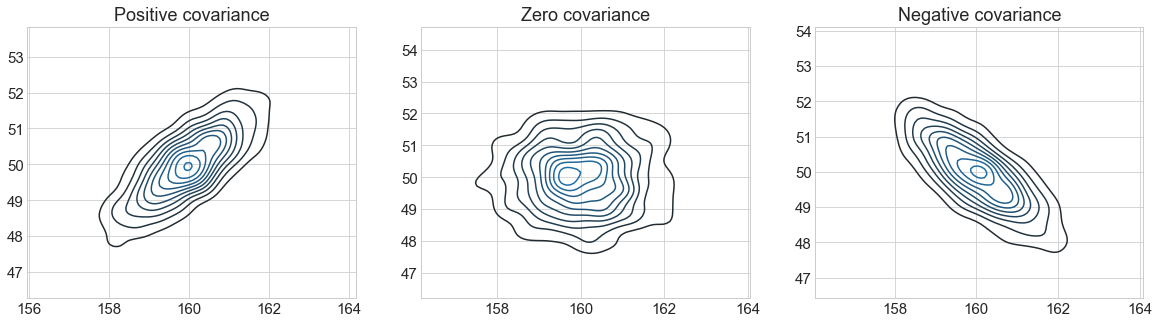

In [6]:
fig, ax = plt.subplots(1,3,figsize=(20,5))


### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[0])
ax[0].set_title('Positive covariance')


### Zero covariance
mean = [160, 50]
cov  = [[1,0],[0,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[1])
ax[1].set_title('Zero covariance')


### Negative covariance
mean = [160, 50]
cov  = [[1,-.8],[-.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[2])
ax[2].set_title('Negative covariance')

plt.show()

This fits nicely on a 2D plot, so we can visualise individual samples from our model very easily (the red x):

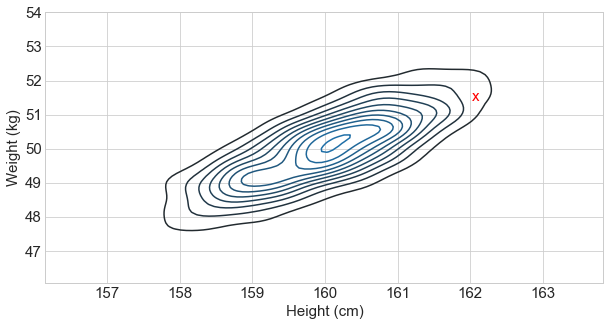

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

s_x, s_y = np.random.multivariate_normal(mean, cov, 1).T

sns.kdeplot(x,y,ax=ax)

ax.annotate('x',(s_x,s_y),color='red')
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Weight (kg)')

plt.show()

One of the mathematical niceties that we get from modelling everything as a Gaussian is that we can take slices 
from the 3D Gaussian above, and get 2D Gaussians as outputs. 

For example, imagine we are given as input a height of 159cm and we would like to output what we think a likely weight might be. We can "condition" our multivariate Gaussian on a height of 159cm by taking a slice through the 3D shape at the 159cm mark. 


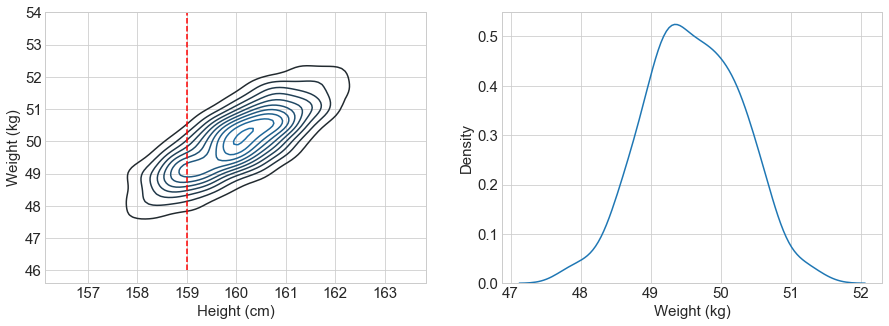

In [8]:
input_height = 159

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.kdeplot(x,y,ax=ax[0])
ax[0].plot([input_height]*10, np.linspace(46,54,10), linestyle='--', color='red')

ax[0].set_xlabel('Height (cm)')
ax[0].set_ylabel('Weight (kg)')

sns.kdeplot(y[x.astype(int) == 159],ax=ax[1]) ## conditioning the Gaussian on height=159
ax[1].set_xlabel('Weight (kg)')
ax[1].set_ylabel('Density')
plt.show()

Unfortunately, this kind of visualisation becomes completely impossible once we have more than three variables (dimensions) to consider. 

A more scalable way to picture taking samples from the distribution is to put each of the variables as individual locations on the x-axis, and to normalise the y-axis:

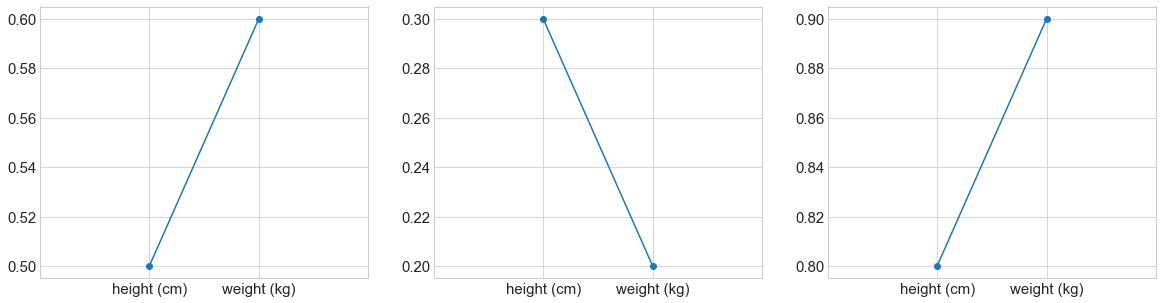

In [9]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()


x = [0,1]
ys = [[0.5,0.6],[0.3,0.2],[0.8,0.9]]

for ax,y in zip(axs,ys):
    ax.plot(x,y, marker='o')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['height (cm)', 'weight (kg)'])
    ax.set_xlim(-1,2)

plt.show()


To see how these samples correspond to samples on the plot above, let's do away with our height/weight example for a moment and imagine that we have two variables ($x_1, x_2$) each in the range 0-1.

To model them, we construct a multivariate Gaussian:

$$ \begin{bmatrix} x_1 \\ x_2 \\ \end{bmatrix} \sim \mathcal{N}\bigg(\mathbf{\mu} = \begin{bmatrix}0.3 \\ 0.6 \\ \end{bmatrix}, \mathbf{\Sigma} = \begin{bmatrix}1&0.9 \\ 0.9 & 1 \\\end{bmatrix}\bigg)$$ 

Now we can take a sample, and picture the sample in two ways:

Sample: 
	 x1:  [-0.77648449]
	 x2:  [0.18437212]


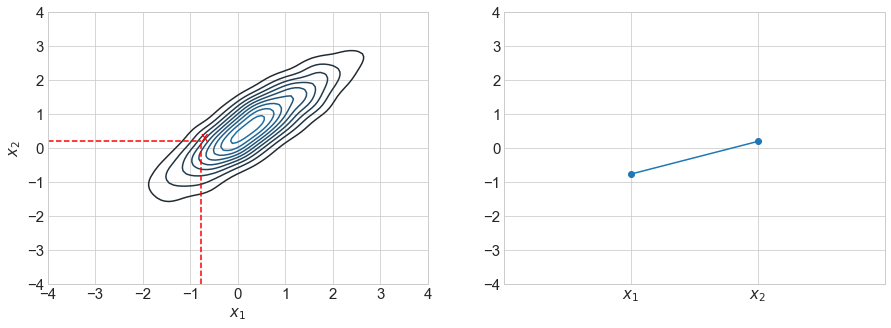

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

### Positive covariance
mean = [0.3,0.6]
cov  = [[1,.9],[.9,1]]  

# set up a Gaussian
x, y = np.random.multivariate_normal(mean, cov, 1000).T
s_x, s_y = np.random.multivariate_normal(mean, cov, 1).T # take a sample

print('Sample: ')
print('\t x1: ',s_x)
print('\t x2: ',s_y)



##### plotting code
## first way to visualise
sns.kdeplot(x,y,ax=ax[0])

ax[0].plot([s_x]*10, np.linspace(-4,s_y,10), linestyle='--',color='red')
ax[0].plot(np.linspace(-4,s_x,10), [s_y]*10, linestyle='--',color='red')
ax[0].annotate('x',(s_x,s_y),color='red')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

## second way to visualise
ax[1].plot([0,1],[s_x,s_y],marker='o')
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['$x_1$','$x_2$'])
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-4,4)

plt.show()


I encourage you to re-run the above cell a few times to get some different samples so that you have a good intuition for how both visualisations work. It's also worth changing the means and covariance matrix and trying to predict what the outputs will look like. 

Something you might notice is that if you decrease the magnitude of the covariance, then the distance between $x_1$ and $x_2$ tends to be larger. This is roughly in line with what we would expect since the covariance describes exactly this. 

In order to do _conditioning_ in our new visualisation system (where we fix one variable at a certain value), all we have to do is fix one of the points at its current location, and continue sampling the others. 

### Generalising to more variables

Imagine now that we add a third variable into the mix: $x_3$. In our population model, this could be something like shoe size.

When designing our new covariance matrix, we decide that $x_3$ is quite related to $x2$, and a little less related to $x1$:

$$ \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ \end{bmatrix} \sim \mathcal{N}\Bigg(\mathbf{\mu} = \begin{bmatrix}0.3 \\ 0.6 \\ 0.4 \\ \end{bmatrix}, \mathbf{\Sigma} = \begin{bmatrix}1&0.9&0.8 \\ 0.9 & 1 & 0.9 \\ 0.8 & 0.9 & 1 \\  \end{bmatrix}\Bigg)$$ 


With three variables, this is a little tricky to visualise sampling the old way, but very natural in our new way:


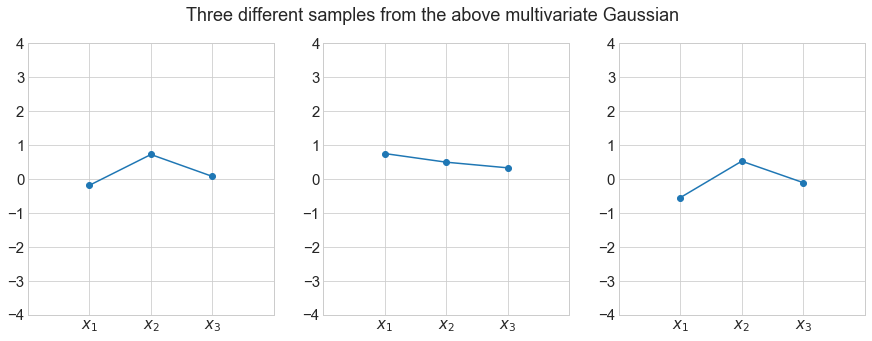

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4]

cov  = [[1., .9, .8],
        [.9, 1., .9],
        [.8, .9, 1.]]

for ax in axs.ravel():
    x1,x2,x3 = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot([1,2,3],[x1,x2,x3], marker='o')
    ax.set_xlim(0,4)
    ax.set_ylim(-4,4)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$'])

    
fig.suptitle('Three different samples from the above multivariate Gaussian')
plt.show()

We can likewise extend this to 4 variables:

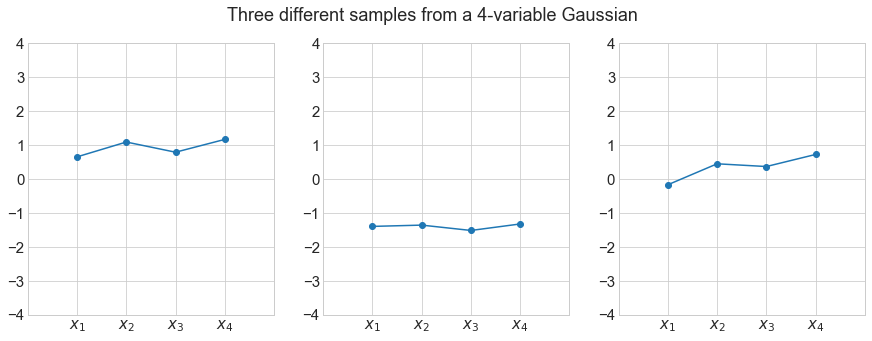

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4,0.5]

cov  = [[1., .9, .8, .7],
        [.9, 1., .9, .8],
        [.8, .9, 1., .9],
        [.7, .8, .9, 1.]]

for ax in axs.ravel():
    x1,x2,x3,x4 = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot([1,2,3,4],[x1,x2,x3,x4], marker='o')
    ax.set_xlim(0,5)
    ax.set_ylim(-4,4)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$','$x_4$'])

    
fig.suptitle('Three different samples from a 4-variable Gaussian')
plt.show()

Or even more:

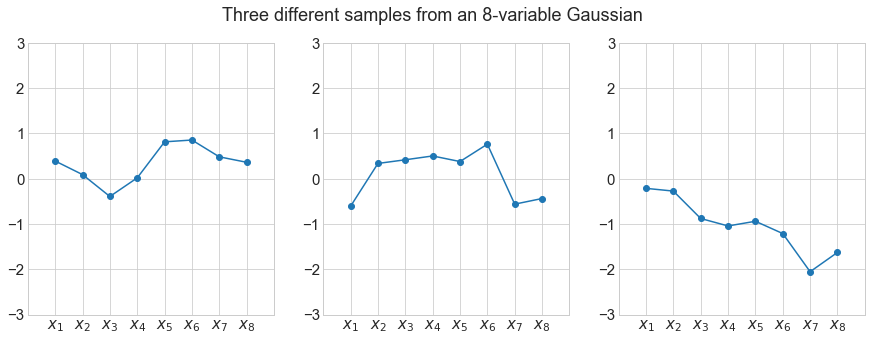

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4,0.5,0.7,0.9,0.1,0.5]

cov  = [[1., .9, .8, .7, .6, .5, .4, .3],
        [.9, 1., .9, .8, .7, .6, .5, .4],
        [.8, .9, 1., .9, .8, .7, .6, .5],
        [.7, .8, .9, 1., .9, .8, .7, .6],
        [.6, .7, .8, .9, 1., .9, .8, .7],
        [.5, .6, .7, .8, .9, 1., .9, .8],
        [.4, .5, .6, .7, .8, .9, 1., .9],
        [.3, .4, .5, .6, .7, .8, .9, 1.]]

for ax in axs.ravel():
    xs = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot(list(range(len(xs))),xs, marker='o')
    
    ax.set_xlim(-1,8)
    ax.set_ylim(-3,3)
    ax.set_xticks(list(range(len(xs))))
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$','$x_8$'])

    
fig.suptitle('Three different samples from an 8-variable Gaussian')
plt.show()

We can generalise this to as many dimensions as we want, and since we're scaling up, I'm going to make use of `sklearn` from now on. 

Let's start by picturing a 1000 dimension multivariate Gaussian. The mean vector, $\mathbf{\mu}$, is just a vector with 1000 elements. The covariance matrix can be visualised as: 

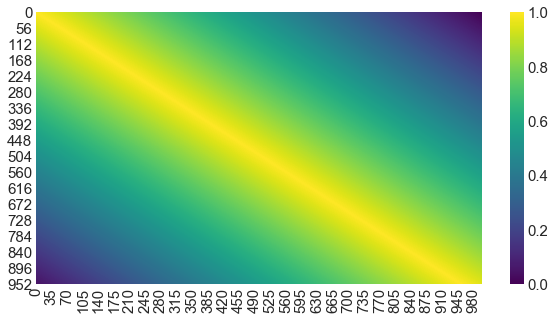

In [14]:
mean  = [0.5]*1000

## the below lines of code are to automatically generate the covariance matrix
## we create the first row, and then we build a symmetric matrix beneath it 
## it's not necessary to understand how this works 
cov_a = np.linspace(1, 0., 1000)
I   = np.arange(cov_a.size)
cov = cov_a[np.abs(I - I[:,None])]

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cov, cmap="viridis", ax=ax)
plt.show()

This is exactly the same as the covariance matrices we had above, just pictured as a heatmap because there are too many numbers to print exactly. The diagonal is all $1$s, and the further away from the diagonal we get, the lower the values become.

Now that we are equipped with a mean vector and a covariance matrix, we can draw some samples:

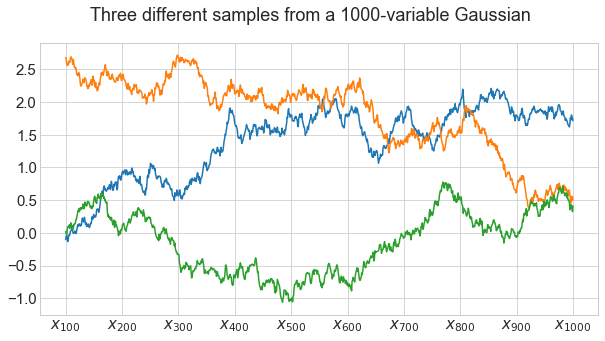

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

s_1 = np.random.multivariate_normal(mean, cov, 1).T
s_2 = np.random.multivariate_normal(mean, cov, 1).T
s_3 = np.random.multivariate_normal(mean, cov, 1).T

ax.plot(list(range(len(s_1))),s_1)
ax.plot(list(range(len(s_2))),s_2)
ax.plot(list(range(len(s_3))),s_3)

ax.set_xticks(np.linspace(0,999,10))
ax.set_xticklabels(['$x_{100}$','$x_{200}$','$x_{300}$','$x_{400}$','$x_{500}$','$x_{600}$','$x_{700}$','$x_{800}$','$x_{900}$','$x_{1000}$'])

    
fig.suptitle('Three different samples from a 1000-variable Gaussian')
plt.show()

Remember how we said we could _condition_ the Gaussian on some variables having a fixed value? Visually, this is akin to fixing a few of the points on that graph, and re-sampling the rest of them.

It turns out, this is **exactly** how Gaussian Processes work. Those samples above are actually *functions* that aren't conditioned on anything. It's for this reason that Gaussian Processes are called "distributions over functions" - we are trying to model all of the possible functions that could produce our data. 

This is quite a lot to take in so I recommend going back up through the examples one more time and making sure that the way we have extended the means/covariance out to many dimensions makes sense. 

## Sampling tricks

One way to make sampling easier (and the code writing easier) is to make it so we are only taking samples from a Gaussian $\mathcal{N}(0,1)$, and then scaling that sample to fit our range. 

First convince yourself that:

$\mathcal{N}(\mu, \sigma^2) = \mu + (\mathcal{N}(0,\sigma^2))$

Picture this as our Gaussian centred at 0 (the mean) being shifted by $\mu$ in the addition.  






## Conditioning multivariate Gaussians 

Please try not to be intimidated; you can take these rules for granted but the actual maths is reasonably straightforward and if you want to see a full derivation then you can look here: [INCLUDE MR LINK]

Imagine we have some data $\mathbf{X}$ and some labels for the data, $\mathbf{y}$. 

We also have a covariance function $K(\circ,\circ)$ which takes two inputs and returns a covariance score. We use this to construct our covariance matrix as usual.

We choose to model $\mathbf{X}$ with a model $f \sim \mathcal{N}(\mu, \Sigma)$. We get some new, unlabelled data, $\mathbf{X_{*}}$, which we can incorporate into our model:

$$ \begin{bmatrix}f \\ f_* \\ \end{bmatrix} \sim
\mathcal{N}\bigg(\begin{bmatrix}\mu \\ \mu_* \\ \end{bmatrix}, 
\begin{bmatrix} K & K_* \\ K_* & K_{**} \end{bmatrix} \bigg)
$$

where $K_* = K(X, X_*)$ and $K_{**} = K(X_*, X_*)$.

To get the distribution over functions that could have produced our *test set*, we can then directly use:

$$ f^* \sim \mathcal{N}(\mu_*, \Sigma_*) $$

This is the key insight and benefit to using Gaussians. This is essentially saying: the covariance function has defined a prior belief about the kind of functions that we could see; we would like to condition the samples on the exact training data we saw, and find slices to get the mean and variance at our test points. More concretely, the above equation produces all of the possible functions that could have passed through our training data, where the *mean* of the functions is our prediction. 

We already have $\mu, \Sigma$ and can easily compute $\Sigma_{**}$. However, we need to calculate $\mu_*, \Sigma*$.

The formulae for these are given by the standard rules for Gaussians:

$ \mu_*    = K_{*}(K+\sigma^2_y I)^{-1}y$  
$ \Sigma_* = K_{**} - K_*^T (K+\sigma^2_y I)^{-1} K_* $

Where $X^{-1}$ means we are [*inverting*](https://www.youtube.com/watch?v=uQhTuRlWMxw&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=7) the matrix. 

Don't worry about deriving these results, just know that whenever you need to fetch $\mu_*$ and $\Sigma_*$ they can be computed exactly with the above formulae. 


## Toy example

Now that we have covered the key topics, let's do some inference with a Gaussian Process. 

I'm going to start by generating a dataset, in this case a noisy sine wave. We'll split the data up into two sets, `train` (which we are allowed to see the targets for) and `test` (which we want to guess the targets for).

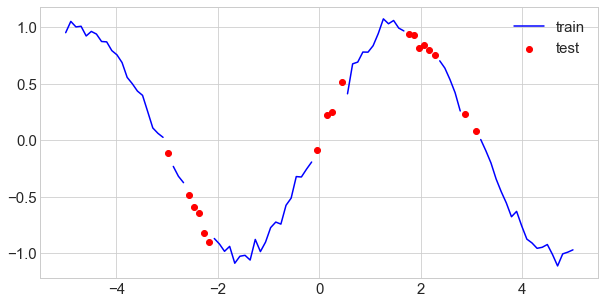

In [72]:
from sklearn.model_selection import train_test_split

noise = 0.05

x = np.linspace(-5.,5.,100)
y = np.sin(x) + np.random.normal(0,noise,100) # add a little noise

#X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

## split into training and test
test_indices  = [20,24,25,26,27,28,49,51,52,54,67,68,69,70,71,72,78,80]
train_indices = [i for i in range(100) if i not in test_indices]

X_train, y_train = x[train_indices], y[train_indices]
X_test, y_test   = x[test_indices], y[test_indices]

fig, ax = plt.subplots(figsize=(10,5))

y_train_with_nans = y
y_train_with_nans[test_indices] = np.nan

ax.plot(x, y_train_with_nans, label='train', color='blue')
ax.scatter(X_test, y_test,label='test', marker='o', color='red')
ax.legend()
plt.show()

So we are going to fit the Gaussian process to the blue points and then try to guess for the red points.

In [73]:
## RBF covariance kernel function
def kernel(a,b,param=.1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    k = np.exp(-.5 * (1/param) * sqdist)
    return k

Let's first calculate $\mu_*$, using the formula:

$ \mu_*    = K_{*}(K+\sigma^2_y I)^{-1}y$  

I'm going to assume that the `noise` parameter $\sigma^2_y$ is known, but in practice we may need to optimise this via gradient-based methods. 

In [74]:
X_train, X_test = np.array(X_train).reshape(-1,1), np.array(X_test).reshape(-1, 1)

K    = kernel(X_train, X_train)
K_s  = kernel(X_train, X_test)
K_ss = kernel(X_test, X_test)

M = K + np.dot(noise, np.eye(len(X_train)))
mu_s = np.dot(kernel(X_test, X_train), np.dot(np.linalg.inv(M),y_train))

And now, 
$ \Sigma_* = K_{**} - K_*^T (K+\sigma^2_y I)^{-1} K_* $

In [75]:
Sigma_s = K_ss - np.dot(K_s.T, np.dot(np.linalg.inv(M), K_s))

And now we can make predictions (by inspecting the mean of the distribution) at our test points! 

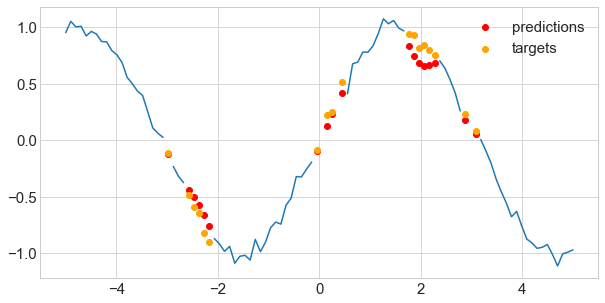

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)
ax.scatter(X_test, mu_s, color='red', label='predictions')
ax.scatter(X_test, y_test, color='orange',label='targets')
ax.legend()
plt.show()

One of the other nice things we can do with Gaussian Processes is inspect the diagonal of the covariance matrix to get uncertainty estimates (i.e. a variance spanning the possible values) at each of the locations.

That is to say, as well as predicting a mean, we also predict a variance: 

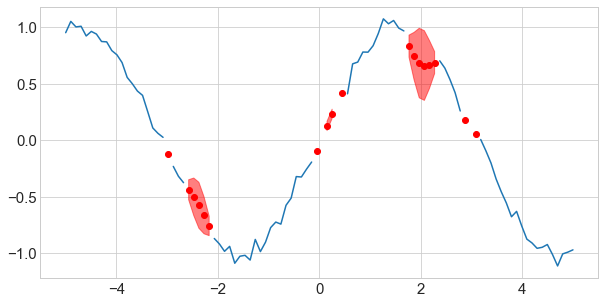

In [91]:
## this is all plotting code

preds = []
lower, upper = [], []
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x,y)

## remove predictions at the training points
lowers_with_nans = []
uppers_with_nans = []

j=0
for i, loc in enumerate(x):
    if loc not in X_test:
        preds.append(np.nan)
        lowers_with_nans.append(np.nan)
        uppers_with_nans.append(np.nan)
    else:
        m = mu_s[j]
        preds.append(m)
        lowers_with_nans.append(m-Sigma_s[j,j])
        uppers_with_nans.append(m+Sigma_s[j,j]) # we fetch the diagonal of the covariance matrix 
        j+=1

ax.scatter(x, preds, color='red', label='predictions')
ax.fill_between(x, lowers_with_nans, uppers_with_nans, color='red', alpha=0.5)

plt.show()

Inverting the covariance matrix `np.linalg.inv(K)` is an extremely expensive option, and is often the main practical obstacle to applying Gaussian Processes to real world data. 

However, there are lots of libraries that have built-in approximations or tricks for speeding up the inversion. I'm not going to discuss any of these tricks since they are a little out-of-scope here, but I will show an example of how we can use the libraries to apply Gaussian Processes in practice. 


## Gaussian Processes with `sklearn`

We're going to repeat the exact same analysis but in `sklearn`, which makes it much simpler.

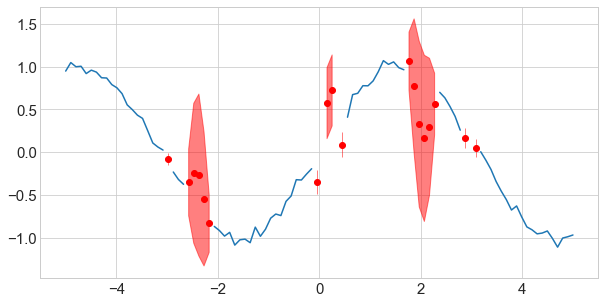

In [89]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## actual Gaussian process code

kernel = RBF(0.1)
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(X_train, y_train)
y_pred, sigma = gp.predict(x.reshape(-1,1), return_std=True) # we can get exact variance estimates

## plotting code

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x,y)
y_pred[train_indices] = np.nan # removing predictions at training points
sigma[train_indices]  = np.nan

ax.scatter(x, y_pred, color='red', label='predictions')
ax.fill_between(x, (y_pred-sigma), (y_pred+sigma), alpha=0.5, color='red')

plt.show()

# Conclusions

In this notebook we have:
- defined the Gaussian distribution for multiple dimensions
- covered covariance, and how we can construct matrices to describe what we expect from our data
- shown how to condition Gaussian distributions on training points, and how to make predictions for unseen points
- replicated our results in a popular machine learning framework 

Gaussian processes are the kind of thing that you probably need to see multiple times before you really get them, so here are a few other resources I recommend:

- [Lecture: Gaussian Processes (Richard Turner)](https://youtu.be/92-98SYOdlY)
- [Lecture: Cornell CS4780 SP17 (Kilian Weinberger)](https://youtu.be/R-NUdqxKjos)
- [Lecture: UBC Machine Learning (Nando de Freitas)](https://youtu.be/4vGiHC35j9s)
- [Blog post: Yuge Shi](https://yugeten.github.io/posts/2019/09/GP/) 
- [sklearn documentation](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)


